In [36]:
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from glob import glob
import multiprocessing
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
from hydra import initialize, compose
import matplotlib

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import diagnostic_plot, plot
from mejiro.utils import util

In [37]:
csv_path = os.path.join('/data','bwedig', 'roman-population', 'data', 'skypy_output.csv')  # dictparaggln_Area00000010
df = pd.read_csv(csv_path)

df.columns

Index(['velodisp', 'massstel', 'angleins', 'redssour', 'redslens', 'xposlens',
       'yposlens', 'xpossour', 'ypossour', 'numbimag', 'magnsour',
       'maxmdistimag', 'magtlensF106', 'magtsourF106', 'magtsourMagnifiedF106',
       'magtlensF129', 'magtsourF129', 'magtsourMagnifiedF129', 'magtlensF158',
       'magtsourF158', 'magtsourMagnifiedF158', 'magtlensF184', 'magtsourF184',
       'magtsourMagnifiedF184'],
      dtype='object')

select histograms to show

In [38]:
velocity_dispersions = df.loc[:,'velodisp']
masses = df.loc[:,'massstel'] * 1e12
source_redshifts = df.loc[:,'redssour']
lens_redshifts = df.loc[:,'redslens']
einstein_radii = df.loc[:,'angleins']
num_images = df.loc[:,'numbimag']
source_magnitudes = df.loc[:,'magtsourF106']
lens_magnitudes = df.loc[:,'magtlensF106']
source_x = df.loc[:,'xpossour']
source_y = df.loc[:,'ypossour']
lens_x = df.loc[:,'xposlens']
lens_y = df.loc[:,'yposlens']

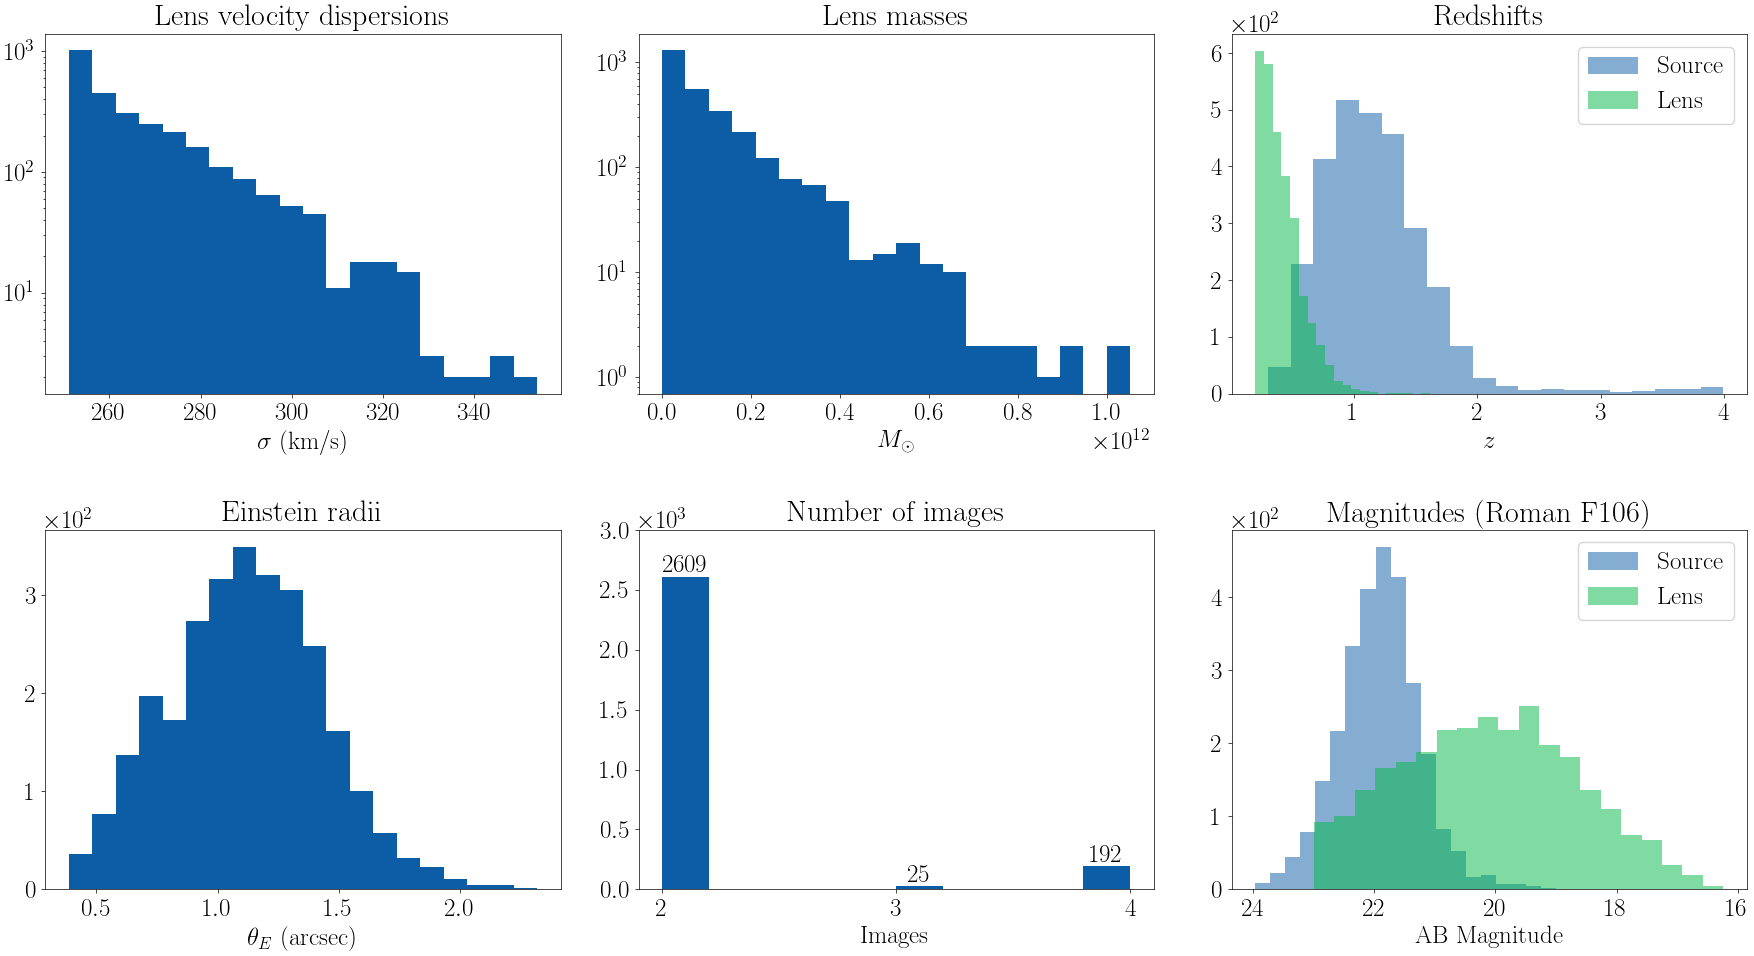

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # , gridspec_kw={'hspace': 0.02, 'wspace': 0.02}

fontsize = 18
matplotlib.rcParams.update({'font.size': fontsize})

bins = 20

from matplotlib.ticker import MaxNLocator

ax[0][0].hist(velocity_dispersions, bins=bins)
ax[0][0].set_xlabel('$\sigma$ (km/s)')
ax[0][0].set_title('Lens velocity dispersions')
ax[0][0].set_yscale('log')

ax[0][1].hist(masses, bins=bins)
ax[0][1].set_xlabel('$M_\odot$')
ax[0][1].set_title('Lens masses')
ax[0][1].set_yscale('log')

ax[0][2].hist(source_redshifts, label='Source', alpha=0.5, bins=bins)
ax[0][2].hist(lens_redshifts, label='Lens', alpha=0.5, bins=bins)
ax[0][2].set_xlabel('$z$')
ax[0][2].set_title('Redshifts')
ax[0][2].legend()

ax[1][0].hist(einstein_radii, bins=bins)
ax[1][0].set_xlabel(r'$\theta_E$ (arcsec)')
ax[1][0].set_title('Einstein radii')

counts, edges, bars = ax[1][1].hist(num_images)
ax[1][1].set_xlabel('Images')
ax[1][1].set_title('Number of images')
labels = [int(v) if v > 0 else '' for v in counts]
ax[1][1].bar_label(bars, labels=labels, label_type='edge')
# ax[1][1].bar_label(bars, fmt=lambda x: x if x > 0 else '')
ax[1][1].set_ylim([0, 3e3])
ax[1][1].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[1][2].hist(source_magnitudes, label='Source', alpha=0.5, bins=bins)
ax[1][2].hist(lens_magnitudes, label='Lens', alpha=0.5, bins=bins)
ax[1][2].set_xlabel('AB Magnitude (Roman F106)')
ax[1][2].set_title('Magnitudes')
ax[1][2].legend()
ax[1][2].invert_xaxis()

for each in ax.flatten()[2:]:  # skip the first two, which are on log scales
    # each.get_yaxis().set_visible(False)
    each.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.tight_layout(w_pad=1.5, h_pad=1.)

plt.savefig(os.path.join(figure_dir, 'skypy_pop_hist.png'))
plt.show()

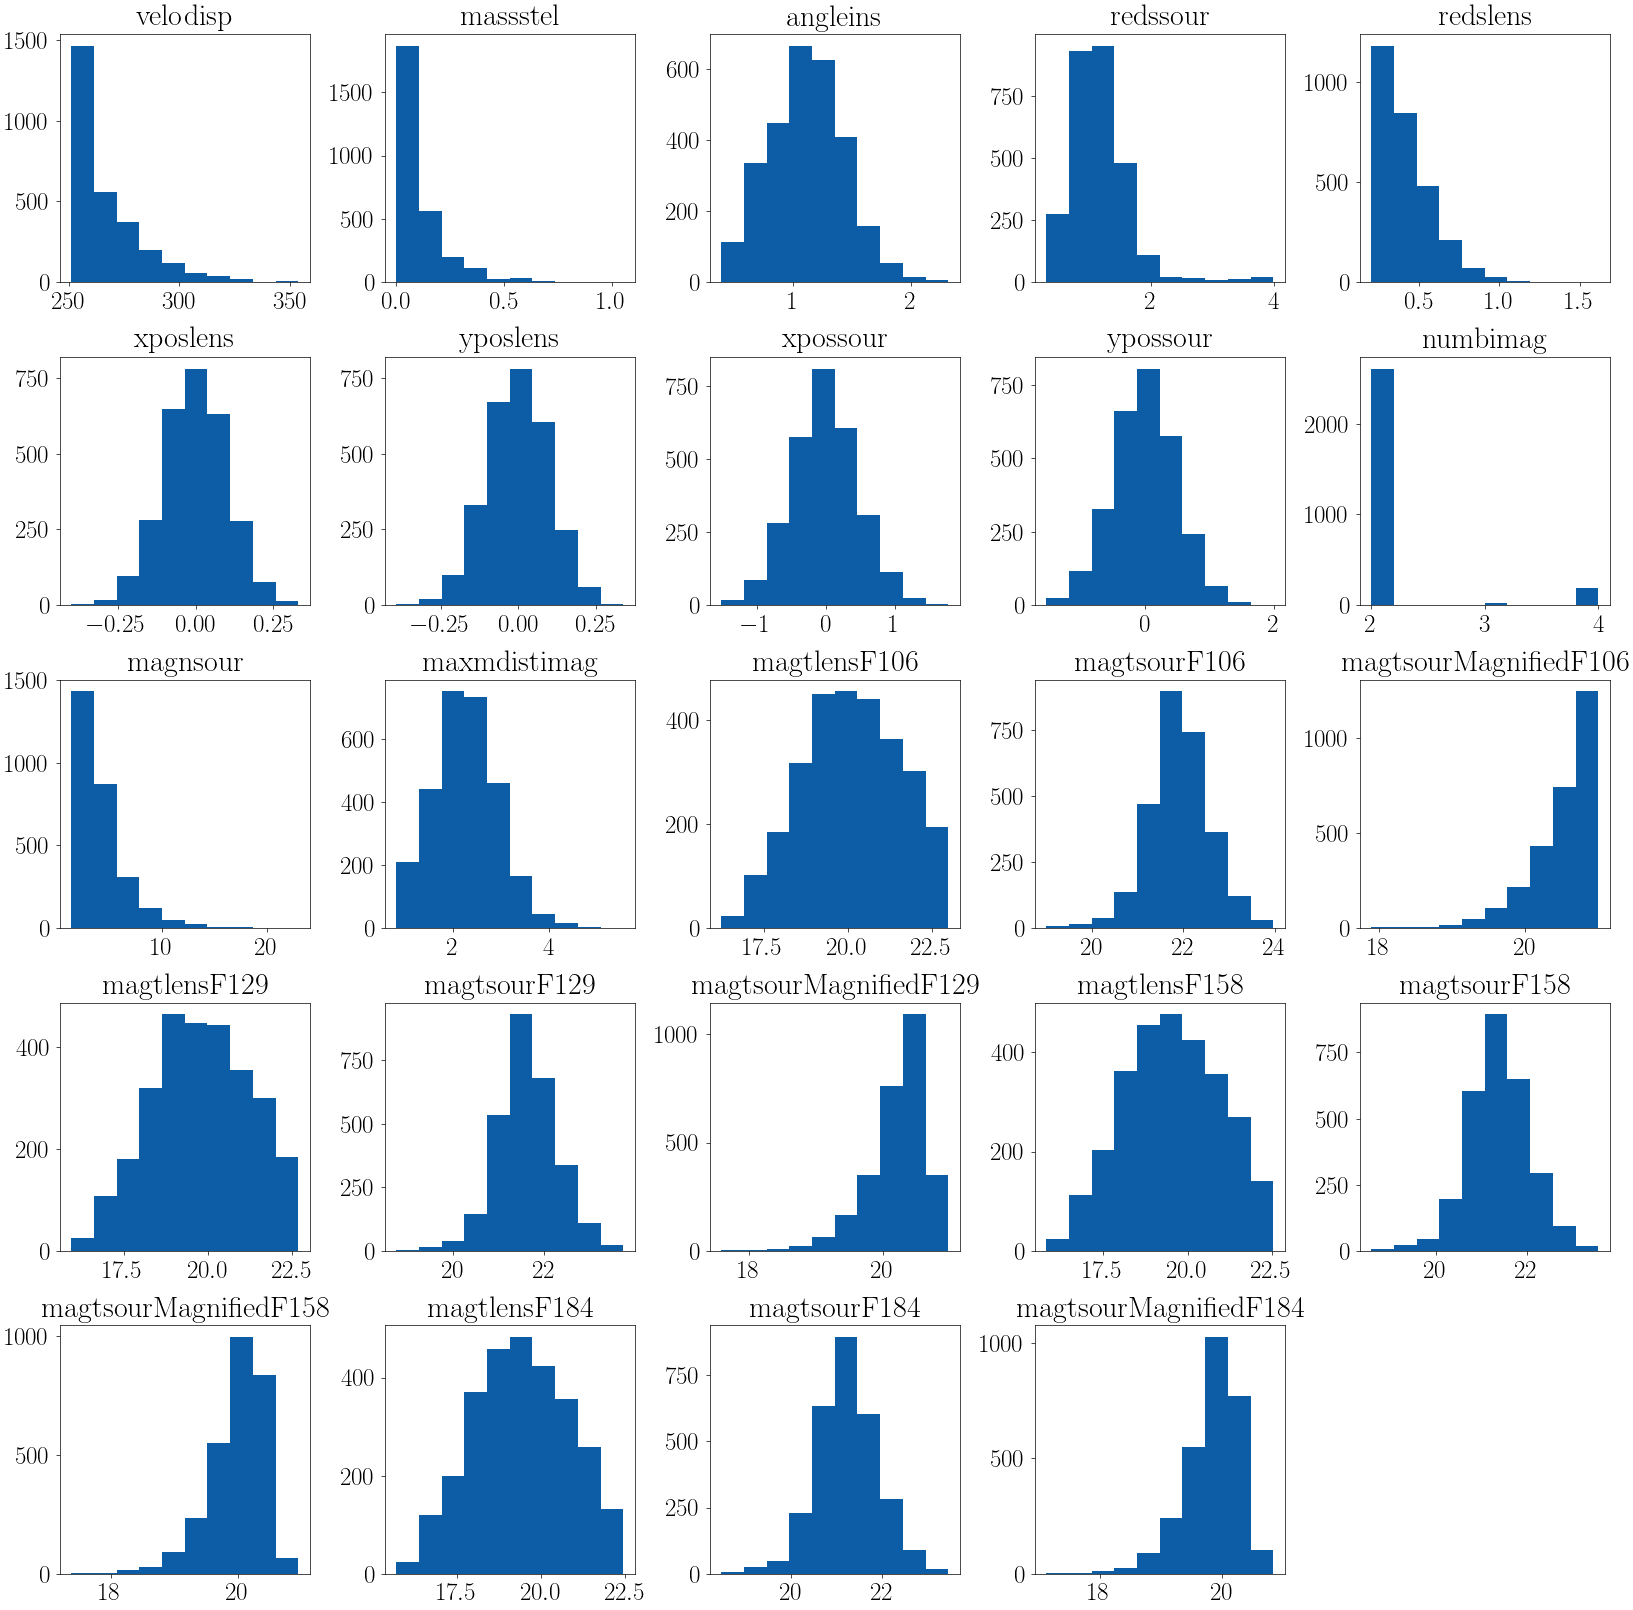

In [40]:
hist = df.hist(grid=False, figsize=(20, 20))
# plt.savefig(os.path.join(figure_dir, 'skypy_pop_hist.png'))